In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import os
from mpl_toolkits.mplot3d import Axes3D

from numpy import linalg as LA
from scipy.spatial import Delaunay

import cv2
import csv
import time

from generalizations import *

from sklearn.neighbors import NearestNeighbors
from info3d import *

In [17]:
# Getting the path to the Raw point clouds

OBJ_DIR = 'point_clouds/'

# Format is a tuple of (file path, file name).
OBJ_PATHS = [ [os.path.join(OBJ_DIR, f), f]
                    for f in os.listdir(OBJ_DIR) ]

OBJ_PATHS.remove(OBJ_PATHS[1]) # remove .DS Store file
OBJ_PATHS

[['point_clouds/Reception-Data61-L5.obj', 'Reception-Data61-L5.obj'],
 ['point_clouds/Driveway.obj', 'Driveway.obj'],
 ['point_clouds/Apartment.obj', 'Apartment.obj'],
 ['point_clouds/Workstations-Data61-L4.obj', 'Workstations-Data61-L4.obj'],
 ['point_clouds/Kitchen-Data61-L4.obj', 'Kitchen-Data61-L4.obj'],
 ['point_clouds/HallWayToKitchen-Data61-L4.obj',
  'HallWayToKitchen-Data61-L4.obj'],
 ['point_clouds/StairWell-Data61-L4.obj', 'StairWell-Data61-L4.obj']]

# Extracting the points, normals, and triangles

In [13]:
new_point_collection = []

new_all_point_collection = []

combining_radius = 2.5

for path, filename in OBJ_PATHS:
    
    pointCloudFile = open(path)#'point_cloud.obj')('SpatialMesh.obj')#

    pointCloudLines = pointCloudFile.readlines()
    
    pointCollection = [] # object_number, vertices, vertex normals, polygons

    pointCollection_no_objects = [[],[],[]] 
    prev_length = 0
    vertices_length = 1
    
    for line in pointCloudLines:

        if line == '\n': continue

        line_items = line.split()

        if line_items[0] == 'o':
            object_item = line_items[1].split('.')
            object_number = int(object_item[-1])
            pointCollection.append([object_number, [], [], []])
            vertices_length += prev_length

            #print(object_number)

        if line_items[0] == 'v':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            if len(line_items)> 4:
                c = line_items[4]
                if float(c) > 0.85:
                    pointCollection[object_number-1][1].append([float(x),float(y),float(z),float(c)])
                    pointCollection_no_objects[0].append([float(x),float(y),float(z),float(c)])
            else:
                pointCollection[object_number-1][1].append([float(x),float(y),float(z)])
                pointCollection_no_objects[0].append([float(x),float(y),float(z)])
            prev_length = len(pointCollection[object_number-1][1])


        if line_items[0] == 'vn':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            pointCollection[object_number-1][2].append([float(x),float(y),float(z)])
            pointCollection_no_objects[1].append([float(x),float(y),float(z)])

        if line_items[0] == 'f':
            p1 = int(line_items[1].split('//')[0])
            p2 = int(line_items[2].split('//')[0])
            p3 = int(line_items[3].split('//')[0])
            pointCollection[object_number-1][3].append([p1-vertices_length,
                                                        p2-vertices_length,
                                                        p3-vertices_length])
            pointCollection_no_objects[2].append([p1-1,p2-1,p3-1])        

    pointCloudFile.close
    print(filename)
    #print(" Length of point collection",len(pointCollection[1][1]))
    print(" Total number of point collections",len(pointCollection))
    
    #Combining objects: 1. Getting centroids
    centroids = []

    for object_name, pointCloud, _vn, triangles in pointCollection:
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length
        normals = np.asarray(_vn)
        
        centroids.append([object_name,
              np.mean(pointCloud[:,0]), # x-axis
              np.mean(pointCloud[:,2]), # z-axis
             ])
        
    centroids = np.asarray(centroids)
    remaining_centroids = np.copy(centroids)
    
    combinedPointCollection = []
    count = 1
    
    while(remaining_centroids.size!=0):
        #print("  ",remaining_centroids[0,0],remaining_centroids.shape)
        #focusing on the first remaining collection, i.e. through its centroid
        collection = np.where(LA.norm(remaining_centroids[:,1:] - remaining_centroids[0,1:], axis = 1)<combining_radius)[0]
        
        #print("  ",collection)
        
        pointCloud = np.asarray(pointCollection[int(remaining_centroids[collection[0],0]-1)][1])
        normals = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][2])
        triangles = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][3])

        for index in collection[1:]:
            
            n_pointCloud = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][1])
            n_normals = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][2])
            n_triangles = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][3])+len(pointCloud)

            pointCloud = np.concatenate((pointCloud,n_pointCloud),0)
            normals = np.concatenate((normals,n_normals),0)
            triangles = np.concatenate((triangles,n_triangles),0)

        combinedPointCollection.append([
            pointCloud,
            normals,
            triangles])
        
        new_all_point_collection.append([
            filename+str(count),
            pointCloud,
            normals,
            triangles])
            
        count += 1
        remaining_centroids = np.delete(remaining_centroids,collection,axis=0)
        #print("   post",remaining_centroids.shape)
        
    print(" Resulting number =",len(combinedPointCollection))
    new_point_collection.append([
        filename,
        combinedPointCollection
    ])

print(len(new_all_point_collection),"total spaces.")

Reception-Data61-L5.obj
 Total number of point collections 37
 Resulting number = 11
Driveway.obj
 Total number of point collections 51
 Resulting number = 11
Apartment.obj
 Total number of point collections 38
 Resulting number = 6
Workstations-Data61-L4.obj
 Total number of point collections 54
 Resulting number = 10
Kitchen-Data61-L4.obj
 Total number of point collections 105
 Resulting number = 18
HallWayToKitchen-Data61-L4.obj
 Total number of point collections 40
 Resulting number = 7
StairWell-Data61-L4.obj
 Total number of point collections 81
 Resulting number = 18
81 total spaces.


In [22]:
# Getting the following properties/attributes of the splices:
#    1. obj_name
#    2-3. xmax, xmin
#    4-5. y_max, ymin
#    6-7. zmax, zmin
#    8. number of points
#    9. the total surface area computer from the mesh

orignalPointCollectionAttributes = [] 

centroids = []

copy_all_point_collection = new_all_point_collection.copy()

for object_name, pointCloud, _vn, triangles in new_all_point_collection:
    pointCloud = np.asarray(pointCloud)
    triangles = np.asarray(triangles)#-vertices_length
    normals = np.asarray(_vn)
    
    if len(pointCloud) < 1000:
        copy_all_point_collection.remove([object_name, pointCloud, _vn, triangles])
        continue

    orignalPointCollectionAttributes.append([
        object_name,
        np.amax(pointCloud[:,0]),np.amin(pointCloud[:,0]),
        np.amax(pointCloud[:,1]),np.amin(pointCloud[:,1]),
        np.amax(pointCloud[:,2]),np.amin(pointCloud[:,2]),
        len(pointCloud),
        getPointCloudArea(pointCloud, triangles)
                                     ])
    
print('Resulting spaces is now {:d} from the orignal {:d} splices'
      .format(len(copy_all_point_collection),len(new_all_point_collection))
     )

Resulting spaces is now 73 from the orignal 81 splices


In [142]:
# Concatenating the point cloud with its normals into a single 2-D array

new_point_collection = []

for object_name, pointCloud, _vn, triangles in copy_all_point_collection:
    
    pointCloud = np.asarray(pointCloud)
    triangles = np.asarray(triangles)#-vertices_length
    normals = np.asarray(_vn)
    
    new_point_collection.append([
        object_name,
        np.concatenate((pointCloud,normals),axis = 1),
        triangles
    ])
    
#with open('point_collection/all_point_collection.pickle','wb') as f: #just 73 after this
#    pickle.dump(new_centered_point_collection,f)

In [16]:
# Testing the resulting point collection

with open('point_collection/all_point_collection.pickle','rb') as f: #just 73 after this
    centered_point_collection = pickle.load(f)
    
print(len(centered_point_collection))

for label, pointCloud, triangles in centered_point_collection[:1]:
    print(label)
    print(pointCloud.shape)
    print(triangles.shape)

73
Reception-Data61-L5.obj1
(6733, 6)
(10818, 3)


# Some example plots and analysis

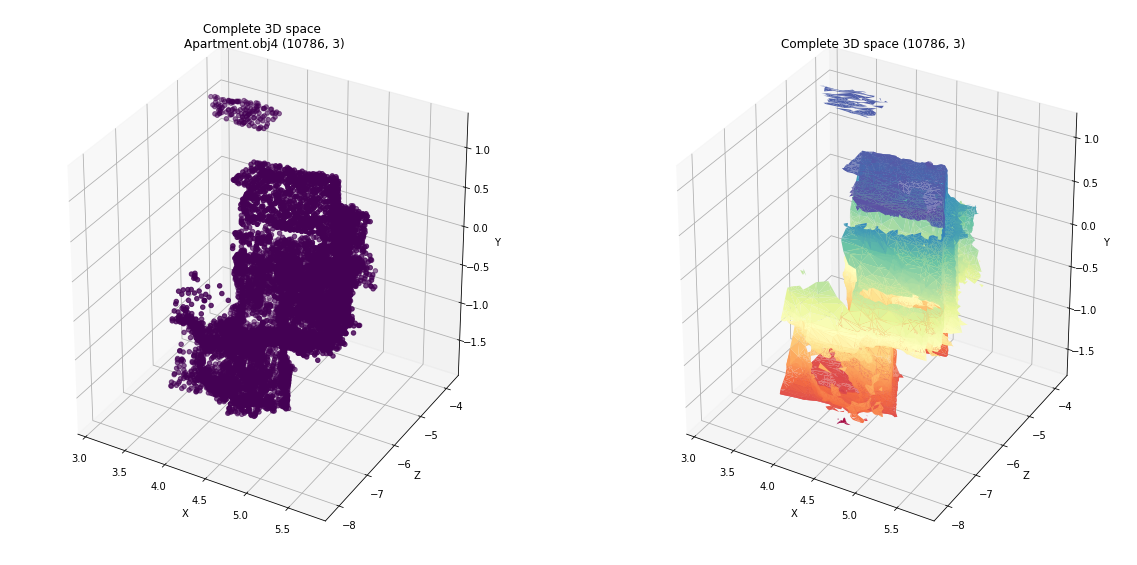

In [128]:
# Plotting a sample space

fig=plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121, projection='3d')

space = 25

pointCloud = np.asarray(new_all_point_collection[space][1])
triangles = np.asarray(new_all_point_collection[space][3])

X = pointCloud[:,0]
Y = pointCloud[:,1]
Z = pointCloud[:,2]
#vertices_length += len(X)
ax1.scatter(X,-Z,Y, c = 3*np.ones(pointCloud.shape[0]))
#color = (object_name%256,object_name%127,object_name%63)
#print(object_name,len(X),triangles.min(),triangles.max())

#ax.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)
        
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_title('Complete 3D space \n'+new_all_point_collection[space][0]+' '+str(pointCloud.shape))

# Add a colorbar
#fig.colorbar(im, ax=ax)

ax2 = fig.add_subplot(122, projection='3d')

#ax1.scatter(X,-Z,Y, c = object_name*3*np.ones(pointCloud.shape[0]))
#color = (object_name%256,object_name%127,object_name%63)
#print(object_name,len(X),triangles.min(),triangles.max())

ax2.plot_trisurf(X, -Z, Y, triangles=triangles, cmap=plt.cm.Spectral)
        
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_zlabel('Y')
ax2.set_title('Complete 3D space '+str(pointCloud.shape))

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)

plt.show()

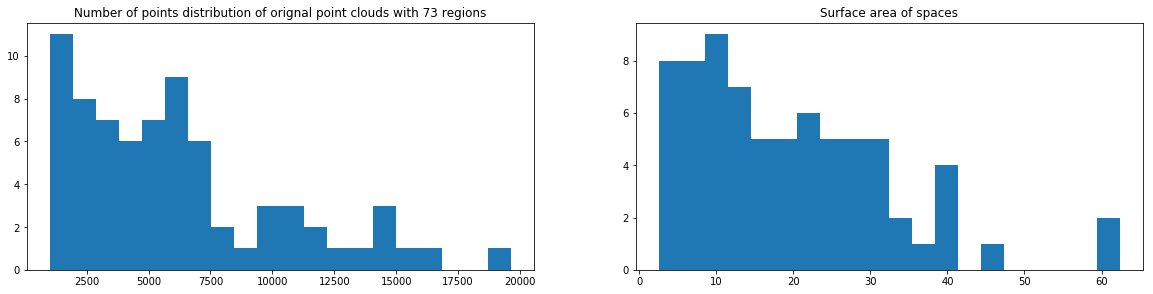

In [23]:
fig = plt.figure(figsize=(20,10))

orignalPointCollectionAttributes = np.asarray(orignalPointCollectionAttributes)

ax1 = fig.add_subplot(221)
ax1.hist(np.asarray(orignalPointCollectionAttributes[:,-2], dtype=np.uint32),bins = 20)
ax1.set_title('Number of points distribution of orignal point clouds with {} regions'.format(len(copy_all_point_collection)))

ax4 = fig.add_subplot(222)
ax4.set_title('Surface area of spaces'.format(len(orignalPointCollectionAttributes)))
ax4.hist(np.asarray(orignalPointCollectionAttributes[:,-1], dtype=np.single),bins = 20);#np.arange(0,7000,500))

#ax3.set_xticks(hist_value);

#combinedProperties

# Getting the spin image descriptors used to describe the spaces

In [138]:
new_descriptors = []

for object_name, pointCloud, _vn, triangles in copy_all_point_collection:
            
    try:
        t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(np.concatenate((pointCloud,_vn),axis = 1))
        #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
    except Exception as ex:
        print(ex)
        print("Error getting the true descriptors of",object_name,"with size",pointCloud.shape)


    print("Done with",object_name)
        
    new_descriptors.append([
        t_descriptors,
        t_keypoints,
        t_d_c,
        object_name
    ])
    
    with open('new_descriptors.pickle','wb') as f:
        pickle.dump(new_descriptors,f)


Done with Reception-Data61-L5.obj1
Done with Reception-Data61-L5.obj2
Done with Reception-Data61-L5.obj3
Done with Reception-Data61-L5.obj4
Done with Reception-Data61-L5.obj6
Done with Reception-Data61-L5.obj7
Done with Reception-Data61-L5.obj8
Done with Reception-Data61-L5.obj10
Done with Driveway.obj1
Done with Driveway.obj2
Done with Driveway.obj3
Done with Driveway.obj4
Done with Driveway.obj5
Done with Driveway.obj7
Done with Driveway.obj8
Done with Driveway.obj9
Done with Driveway.obj11
Done with Apartment.obj1
Done with Apartment.obj2
Done with Apartment.obj3
Done with Apartment.obj4
Done with Apartment.obj5
Done with Apartment.obj6
Done with Workstations-Data61-L4.obj1
Done with Workstations-Data61-L4.obj2
Done with Workstations-Data61-L4.obj3
Done with Workstations-Data61-L4.obj4
Done with Workstations-Data61-L4.obj5
Done with Workstations-Data61-L4.obj6
Done with Workstations-Data61-L4.obj7
Done with Workstations-Data61-L4.obj8
Done with Workstations-Data61-L4.obj9
Done with 

# Rotating the entire collection about the same axis and angle.

In [25]:
random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
random_axis = np.random.choice(np.arange(0,3))
rotatedPointCollection = rotatePointCollection(centered_point_collection,theta = random_theta, axis = random_axis)
print("theta = {:.2f} degrees, axis = {}".format(random_theta*180/np.pi, random_axis))

theta = 80.12 degrees, axis = 1


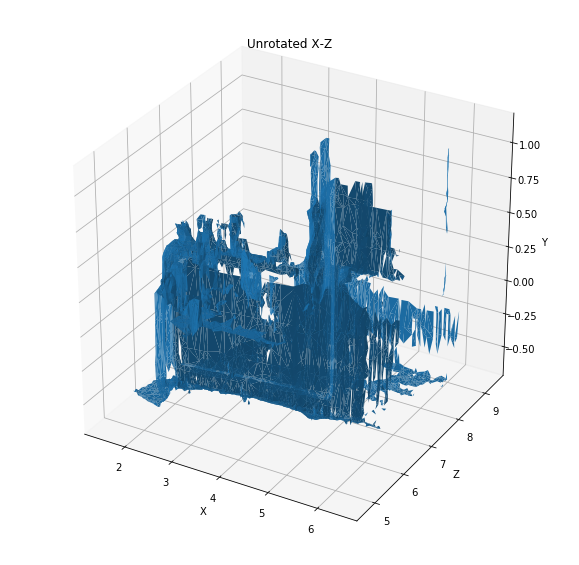

In [27]:
fig=plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

#vertices_length = 1

for object_name, pointCloud, triangles in centered_point_collection[:1]:
    
    #if any(object_name-1 == item for item in [0,34,7,18,13,38,30]):
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length

        X = pointCloud[:,0]
        Y = pointCloud[:,1]
        Z = pointCloud[:,2]
        #vertices_length += len(X)
        #im = ax.scatter(X,Y,Z, c = object_name*3*np.ones(pointCloud.shape[0]))
        #color = (object_name%256,object_name%127,object_name%63)
        #print(object_name,len(X),triangles.min(),triangles.max())
        try:
            ax.plot_trisurf(X, -Z, Y, triangles=triangles)#, cmap=plt.cm.Spectral)
        except:
            pass
        
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Unrotated')

# Add a colorbar
#fig.colorbar(im, ax=ax)

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)

plt.show()

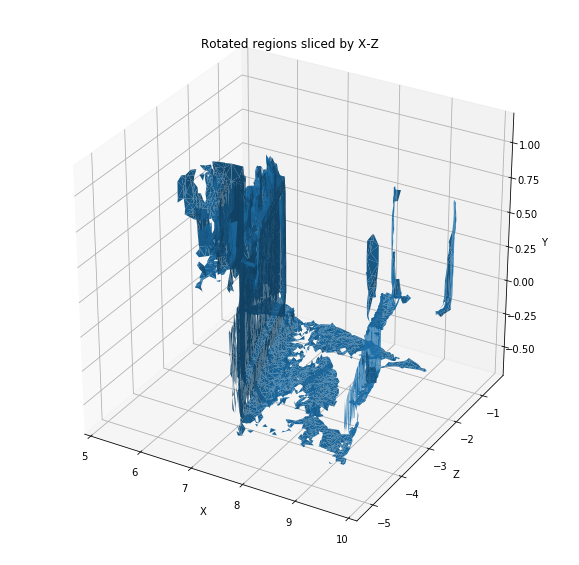

In [28]:
fig=plt.figure(figsize=(10, 10))


ax = fig.add_subplot(111, projection='3d')

#vertices_length = 1

for object_name, pointCloud, triangles in rotatedPointCollection[:1]:
    
    #if any(object_name-1 == item for item in [0,34,7,18,13,38,30]):
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length

        X = pointCloud[:,0]
        Y = pointCloud[:,1]
        Z = pointCloud[:,2]
        #vertices_length += len(X)
        #im = ax.scatter(X,Y,Z, c = object_name*3*np.ones(pointCloud.shape[0]))
        #color = (object_name%256,object_name%127,object_name%63)
        #print(object_name,len(X),triangles.min(),triangles.max())
        try:
            ax.plot_trisurf(X, -Z, Y, triangles=triangles)#, cmap=plt.cm.Spectral)
        except:
            pass
        
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_title('Rotated ')

# Add a colorbar
#fig.colorbar(im, ax=ax)

# set the color limits - not necessary here, but good to know how.
#im.set_clim(0.0, 1.0)

plt.show()

# RANSAC Plane Fitting
Trying RANSAC plane fitting to estimate planes from the sense point cloud (from Hololens).

# Pseudocode

    Input:
    X = {x_1 , x_2 , ..., x_n}, a s et of 3D points
    P the number of planes to find
    T the point-plane distance threshold
    R the number of RANSAC trials
    
    for p = 1 to P:
        bestPlane = {0,0}
        bestPoints = {}
        for r = 1 to R:
            S = {s_1 , s_2 , s_3} = 3 points at random f rom X
            thisPlane = {s_1 , crossProduct(s_3 -s_1 , s_2 -s_1)}
            thisPoints = {}
            for x_i in X:
                if (distance(thisPlane , x_i) < T):
                    thisPoints = thisPoints + x_i
            if |thisPoints| > |bestPoints |:
                bestPlane = thisPlane
                bestPoints = thisPoints
                
        output bestPlane
        X = X - bestPoints